# Kinetics - NOx Submechanism

```
Created for ME 4443 @ LSU (Spring 2018)
```

In [1]:
# modules used
import cantera as ct
import numpy as np
import graphviz
import os

import matplotlib.pyplot as plt
%matplotlib notebook

### Reaction Mechanism

Reactions/species:
 * `gas.n_species`
 * `gas.species_names`
 * `gas.n_reactions`
 * `gas.reaction_equations()`

Stoichiometric coefficient matrices:
 * `gas.reactant_stoich_coeffs()`
 * `gas.product_stoich_coeffs()`

Equilibrium constant and rate constants:  
 * `gas.equilibrium_constants`
 * `gas.forward_rate_constants`
 * `gas.reverse_rate_constants`
 
Rate of progress (product of concentrations and rate constants)
 * `gas.forward_rates_of_progress`
 * `gas.reverse_rates_of_progress`
 * `gas.net_rates_of_progress`
 
Species creation rates:
 * `gas.creation_rates`
 * `gas.destruction_rates`
 * `gas.net_production_rates`
 
### Reactor Networks

A _Reactor Network_ can be used to track the state of a mixture over time. Advancing by a short time step allows reactions to take place, i.e. radicals, intermediate species, etc. will form. Below is a simple example:

```
r = ct.IdealGasReactor(gas)
net = ct.ReactorNet([r])
net.advance(1.e-3) # <--- elapsed time
```

## Analyze NO Sub-Mechanism

In [2]:
# Reduce species
all_species = ct.Species.listFromFile('gri30.xml')
species = []

# Filter species
for S in all_species:
    comp = S.composition
    if 'C' in comp:
        # exclude all carbon compounds
        continue
    if 'H' in comp and S.name not in {'OH','H2','H', 'H2O'}:
        # exclude most compounds including H (but )
        continue
    if S.name in {'AR','N2O'}:
        # exclude some remaining species
        continue

    species.append(S)

species_names = {S.name for S in species}
print('Species: {0}'.format(', '.join(S.name for S in species)))

Species: H2, H, O, O2, OH, H2O, N, NO, NO2, N2


In [3]:
# Filter reactions, keeping only those that only involve the selected species
all_reactions = ct.Reaction.listFromFile('gri30.xml')
reactions = []

print('\nReactions:')
for R in all_reactions:
    if not all(reactant in species_names for reactant in R.reactants):
        continue

    if not all(product in species_names for product in R.products):
        continue

    reactions.append(R)
    print(R.equation)


Reactions:
2 O + M <=> O2 + M
H + O + M <=> OH + M
H2 + O <=> H + OH
H + O2 <=> O + OH
2 H + M <=> H2 + M
2 H + H2 <=> 2 H2
2 H + H2O <=> H2 + H2O
H + OH + M <=> H2O + M
H2 + OH <=> H + H2O
2 OH <=> H2O + O
N + NO <=> N2 + O
N + O2 <=> NO + O
N + OH <=> H + NO
NO + O + M <=> NO2 + M
NO2 + O <=> NO + O2
H + NO2 <=> NO + OH


In [4]:
gas = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                species=species, reactions=reactions)

### Initial State

get some information on the mechanism

In [5]:
pres = 101325.0      # pressure
temp = 2100.         # temperature
comp = 'N2:.79,O2:.21,H2O:.01' # include trace amount of H2O

In [6]:
# set state
gas.TPX = temp,pres,comp
gas()


       temperature            2100  K
          pressure          101325  Pa
           density          0.1668  kg/m^3
  mean mol. weight         28.7431  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy       2.025e+06        5.821e+07     J
   internal energy      1.4176e+06        4.075e+07     J
           entropy          9118.1        2.621e+05     J/K
    Gibbs function     -1.7123e+07       -4.922e+08     J
 heat capacity c_p          1276.9         3.67e+04     J/K
 heat capacity c_v          987.65        2.839e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.207921         0.231472         -30.5107
               H2O     0.00990099       0.00620563         -46.1514
                N2       0.782178         0.762323         -27.3428
     [   +7 minor]              0   

### After Advancing Reactions

In [7]:
# create reactor and take small step to get non-zero radical concentrations
gas.TPX = temp,pres,comp
r = ct.IdealGasReactor(gas,energy='off')
net = ct.ReactorNet([r])
net.advance_to_steady_state()
#net.advance(1.e-3)
gas()


       temperature            2100  K
          pressure          101382  Pa
           density          0.1668  kg/m^3
  mean mol. weight         28.7268  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      2.0674e+06        5.939e+07     J
   internal energy      1.4596e+06        4.193e+07     J
           entropy          9141.4        2.626e+05     J/K
    Gibbs function      -1.713e+07       -4.921e+08     J
 heat capacity c_p          1276.9        3.668e+04     J/K
 heat capacity c_v          987.43        2.837e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2    1.23595e-05      8.67316e-07          -30.936
                 H    1.09594e-05      3.84534e-07          -15.468
                 O     0.00062479      0.000347977         -15.2686
                O2       0.202369   

#### Reaction Rates of Progress / Species Production

get information on species creation/destruction rates

In [8]:
# Get the reaction objects, and sort them so the most active reactions are first
R = sorted(zip(gas.forward_rates_of_progress, gas.reactions()), key=lambda x: -np.abs(x[0]))
R

[(0.19739687517262647, <ElementaryReaction: H + O2 <=> O + OH>),
 (0.18357617985351088, <ElementaryReaction: 2 OH <=> H2O + O>),
 (0.0040651345689079908, <ElementaryReaction: H2 + OH <=> H + H2O>),
 (0.0027340921680154328, <ThreeBodyReaction: NO + O + M <=> NO2 + M>),
 (0.0020978910741396082, <ElementaryReaction: H2 + O <=> H + OH>),
 (0.0012297572827989487, <ElementaryReaction: NO2 + O <=> NO + O2>),
 (0.00063232599952216381, <ElementaryReaction: H + NO2 <=> NO + OH>),
 (8.5802215476505104e-05, <ElementaryReaction: N + O2 <=> NO + O>),
 (2.571692562860953e-05, <ElementaryReaction: N + NO <=> N2 + O>),
 (1.084861277348018e-05, <ThreeBodyReaction: H + OH + M <=> H2O + M>),
 (4.956846973981777e-06, <ThreeBodyReaction: 2 O + M <=> O2 + M>),
 (3.2271828792072313e-06, <ElementaryReaction: N + OH <=> H + NO>),
 (3.3413198988558221e-07, <ThreeBodyReaction: H + O + M <=> OH + M>),
 (1.1091382433778121e-08, <ThreeBodyReaction: 2 H + M <=> H2 + M>),
 (9.3116053324709512e-10, <ElementaryReaction:

In [9]:
# Get the reaction objects, and sort them so the most active reactions are first
R = sorted(zip(gas.reverse_rates_of_progress, gas.reactions()), key=lambda x: -np.abs(x[0]))
R

[(0.1973968751726268, <ElementaryReaction: H + O2 <=> O + OH>),
 (0.18357617985351138, <ElementaryReaction: 2 OH <=> H2O + O>),
 (0.0040651345689080012, <ElementaryReaction: H2 + OH <=> H + H2O>),
 (0.0027340921680154649, <ThreeBodyReaction: NO + O + M <=> NO2 + M>),
 (0.0020978910741396087, <ElementaryReaction: H2 + O <=> H + OH>),
 (0.0012297572827989426, <ElementaryReaction: NO2 + O <=> NO + O2>),
 (0.00063232599952216164, <ElementaryReaction: H + NO2 <=> NO + OH>),
 (8.5802215486293132e-05, <ElementaryReaction: N + O2 <=> NO + O>),
 (2.571692561845312e-05, <ElementaryReaction: N + NO <=> N2 + O>),
 (1.0848612773480371e-05, <ThreeBodyReaction: H + OH + M <=> H2O + M>),
 (4.9568469739818219e-06, <ThreeBodyReaction: 2 O + M <=> O2 + M>),
 (3.2271828795753603e-06, <ElementaryReaction: N + OH <=> H + NO>),
 (3.3413198988558523e-07, <ThreeBodyReaction: H + O + M <=> OH + M>),
 (1.1091382433778282e-08, <ThreeBodyReaction: 2 H + M <=> H2 + M>),
 (9.3116053324710866e-10, <ElementaryReaction

In [10]:
# Get the reaction objects, and sort them so the most active reactions are first
R = sorted(zip(gas.net_rates_of_progress, gas.reactions()), key=lambda x: -np.abs(x[0]))
R

[(1.0156409540424891e-14, <ElementaryReaction: N + NO <=> N2 + O>),
 (-9.7880281354004173e-15, <ElementaryReaction: N + O2 <=> NO + O>),
 (-4.9960036108132044e-16, <ElementaryReaction: 2 OH <=> H2O + O>),
 (-3.6812898920619147e-16, <ElementaryReaction: N + OH <=> H + NO>),
 (-3.3306690738754696e-16, <ElementaryReaction: H + O2 <=> O + OH>),
 (-3.2092384305570931e-17, <ThreeBodyReaction: NO + O + M <=> NO2 + M>),
 (-1.0408340855860843e-17, <ElementaryReaction: H2 + OH <=> H + H2O>),
 (6.0715321659188248e-18, <ElementaryReaction: NO2 + O <=> NO + O2>),
 (2.1684043449710089e-18, <ElementaryReaction: H + NO2 <=> NO + OH>),
 (-4.3368086899420177e-19, <ElementaryReaction: H2 + O <=> H + OH>),
 (-1.9142944607947188e-19, <ThreeBodyReaction: H + OH + M <=> H2O + M>),
 (-4.4892746204477918e-20, <ThreeBodyReaction: 2 O + M <=> O2 + M>),
 (-3.017554874593445e-21, <ThreeBodyReaction: H + O + M <=> OH + M>),
 (-1.6047303883528737e-22, <ThreeBodyReaction: 2 H + M <=> H2 + M>),
 (-1.3545082530555828e-

In [11]:
# Get the reaction objects, and sort them so the most active species are first
S = sorted(zip(gas.creation_rates, gas.species()), key=lambda x: -np.abs(x[0]))
S

[(0.57135899644986199, <Species OH>),
 (0.3871565625181343, <Species O>),
 (0.20420666078845623, <Species H>),
 (0.19871739151788603, <Species O2>),
 (0.18765216489751341, <Species H2O>),
 (0.0061630376663873538, <Species H2>),
 (0.004710921774310743, <Species NO>),
 (0.0045961754503365372, <Species NO2>),
 (0.00011474632398432162, <Species N>),
 (2.571692562860953e-05, <Species N2>)]

In [12]:
# Get the reaction objects, and sort them so the most active species are first
S = sorted(zip(gas.destruction_rates, gas.species()), key=lambda x: -np.abs(x[0]))
S

[(0.57135899644986099, <Species OH>),
 (0.38715656251813491, <Species O>),
 (0.20420666078845631, <Species H>),
 (0.19871739151787587, <Species O2>),
 (0.18765216489751393, <Species H2O>),
 (0.0061630376663873434, <Species H2>),
 (0.004710921774331015, <Species NO>),
 (0.004596175450336578, <Species NO2>),
 (0.00011474632398432186, <Species N>),
 (2.571692561845312e-05, <Species N2>)]

In [13]:
# Get the reaction objects, and sort them so the most active species are first
S = sorted(zip(gas.net_production_rates, gas.species()), key=lambda x: -np.abs(x[0]))
S

[(-2.0272234344215039e-14, <Species NO>),
 (1.0156409540424891e-14, <Species N2>),
 (1.0127121682207679e-14, <Species O2>),
 (1.0465942802043279e-15, <Species OH>),
 (-5.1020013138326076e-16, <Species H2O>),
 (-4.377385273884643e-16, <Species O>),
 (-4.7877712843599726e-17, <Species H>),
 (-4.0332320816460765e-17, <Species NO2>),
 (1.0841847702896659e-17, <Species H2>),
 (-2.524158182817815e-19, <Species N>)]

### Reaction Path Diagram

In [14]:
element = 'N'

diagram = ct.ReactionPathDiagram(gas, element)
diagram.title = 'Reaction path diagram following {0}'.format(element)
#diagram.label_threshold = 0.01
diagram.flow_type = 'OneWayFlow'
diagram.threshold = 1.e-10

dot_file = 'rxnpath.dot'
img_file = 'rxnpath.png'
img_path = os.path.join(os.getcwd(), img_file)

diagram.write_dot(dot_file)
#print(diagram.get_data())

print("Wrote graphviz input file to '{0}'.".format(os.path.join(os.getcwd(), dot_file)))

Wrote graphviz input file to '/home/ischoegl/Desktop/lsucombustion/ME4443/examples/rxnpath.dot'.


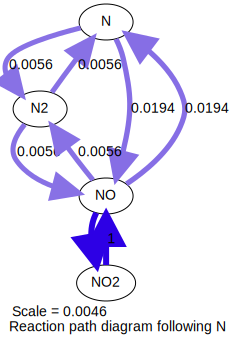

In [15]:
with open(dot_file) as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [16]:
element = 'O'

diagram = ct.ReactionPathDiagram(gas, element)
diagram.title = 'Reaction path diagram following {0}'.format(element)
#diagram.label_threshold = 0.01
diagram.flow_type = 'OneWayFlow'
diagram.threshold = 1.e-10

dot_file = 'rxnpath.dot'
img_file = 'rxnpath.png'
img_path = os.path.join(os.getcwd(), img_file)

diagram.write_dot(dot_file)
#print(diagram.get_data())

print("Wrote graphviz input file to '{0}'.".format(os.path.join(os.getcwd(), dot_file)))

Wrote graphviz input file to '/home/ischoegl/Desktop/lsucombustion/ME4443/examples/rxnpath.dot'.


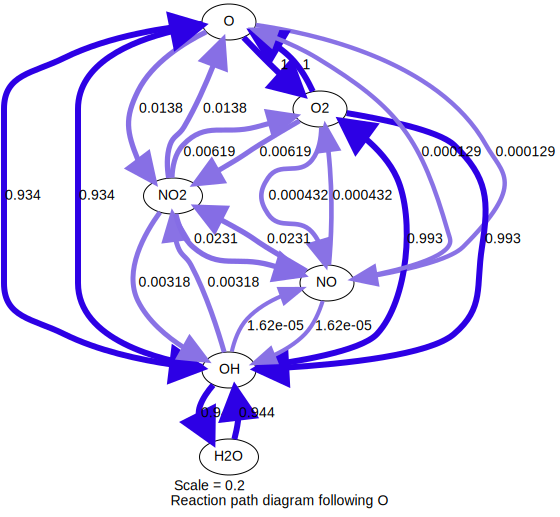

In [17]:
with open(dot_file) as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))